#  Step 1: Exploratory Data Analysis & Data Audit  　
**Objective:** To assess data quality, identify compliance risks (fairness), detect data leakage, and formulate a robust preprocessing strategy.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.preprocessing import LabelEncoder

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
data_path = "../data/raw/dataproject2025.csv"
df = pd.read_csv(data_path)

# Drop artifact columns immediately (Index or old predictions)
cols_to_drop = ['Unnamed: 0', 'Predictions', 'Predicted probabilities']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

print(f"Data loaded. Shape: {df.shape}")
df.head(10)

Data loaded. Shape: (1086236, 36)


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900
5,2013,0,40000.0,2268.0,1428.0,79.6,0.0,16.94,10+ years,other,664.0,12000.0,B,RENT,0.0,13.53,182.0,1.0,1.0,0.0,11.0,2.0,14.0,8.0,24.0,7.0,2.0,0.0,debt_consolidation,5572.0,68.8,B5,0,0.0,871,2.922946
6,2013,1,32760.0,2060.0,2689.0,70.1,0.0,27.06,4 years,other,679.0,11500.0,E,RENT,0.0,22.90,177.0,14.0,1.0,0.0,20.0,5.0,7.0,4.0,13.0,12.0,0.0,0.0,debt_consolidation,9996.0,70.9,E4,0,0.0,937,6.622258
7,2013,0,100000.0,15372.0,4822.0,77.6,0.0,22.18,10+ years,driver,664.0,24000.0,B,MORTGAGE,0.0,13.53,299.0,18.0,7.0,3.0,18.0,3.0,10.0,17.0,19.0,14.0,0.0,0.0,credit_card,21617.0,76.7,B5,0,0.0,493,1.673871
8,2013,0,81500.0,869.0,6811.0,54.6,0.0,16.73,10+ years,operations manager,689.0,20800.0,B,RENT,2.0,13.53,186.0,0.0,0.0,0.0,0.0,8.0,17.0,1.0,40.0,29.0,0.0,0.0,debt_consolidation,23473.0,54.5,B5,0,0.0,100,14.736242
9,2013,0,25000.0,3906.0,2050.0,52.3,0.0,24.68,10+ years,other,664.0,3000.0,B,RENT,0.0,12.85,271.0,7.0,7.0,6.0,14.0,2.0,6.0,11.0,9.0,5.0,2.0,2.0,debt_consolidation,2875.0,54.2,B4,0,0.0,322,28.112088


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 36 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   issue_d                1086236 non-null  int64  
 1   loan duration          1086236 non-null  int64  
 2   annual_inc             1086236 non-null  float64
 3   avg_cur_bal            1086236 non-null  float64
 4   bc_open_to_buy         1086236 non-null  float64
 5   bc_util                1086236 non-null  float64
 6   delinq_2yrs            1086236 non-null  float64
 7   dti                    1086236 non-null  float64
 8   emp_length             1086236 non-null  object 
 9   emp_title              1086236 non-null  object 
 10  fico_range_high        1086236 non-null  float64
 11  funded_amnt            1086236 non-null  float64
 12  grade                  1086236 non-null  object 
 13  home_ownership         1086236 non-null  object 
 14  inq_last_6mths    

# Part 1: Exploratory Data Analysis (EDA)
Goal: Understand the risk drivers and identify potential bias proxies.

### 1.1 Target Distribution (Default Probability)

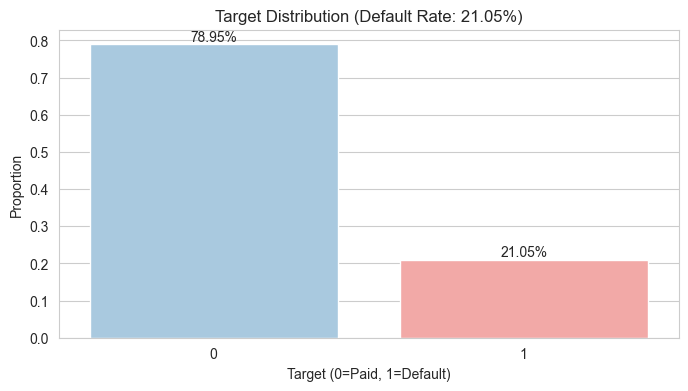

In [5]:
# Default Rate
target_counts = df['target'].value_counts(normalize=True)
default_rate = target_counts[1]


plt.figure(figsize=(8, 4))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=['#A0CBE8', '#FF9D9A'])
plt.title(f"Target Distribution (Default Rate: {default_rate:.2%})")
plt.xlabel("Target (0=Paid, 1=Default)")
plt.ylabel("Proportion")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.show()

### 1.2 Borrower Profile

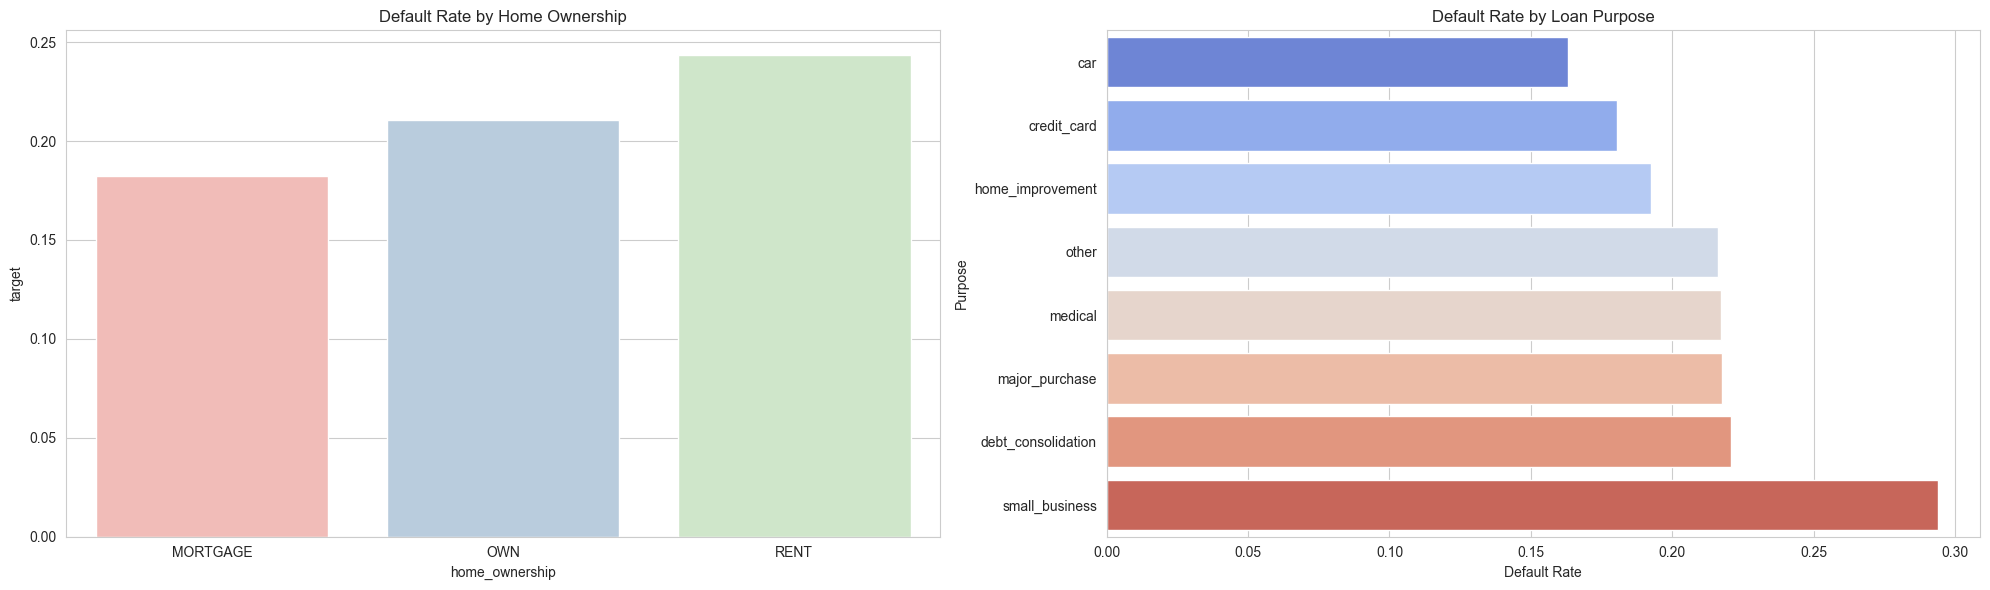

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Home Ownership
sns.barplot(x='home_ownership', y='target', data=df, ax=axes[0], palette='Pastel1', ci=None)
axes[0].set_title("Default Rate by Home Ownership")

# Purpose
top_purposes = df['purpose'].value_counts().nlargest(8).index
sorted_df = (
    df[df['purpose'].isin(top_purposes)]
    .groupby('purpose')['target']
    .mean()
    .sort_values()   
    .reset_index()
)

sns.barplot(
    y='purpose',
    x='target',
    data=sorted_df,
    ax=axes[1],
    palette='coolwarm',
    ci=None
)
axes[1].set_title("Default Rate by Loan Purpose")
axes[1].set_xlabel("Default Rate")
axes[1].set_ylabel("Purpose")


plt.tight_layout()
plt.show()

### 1.3 Annual Income Distribution

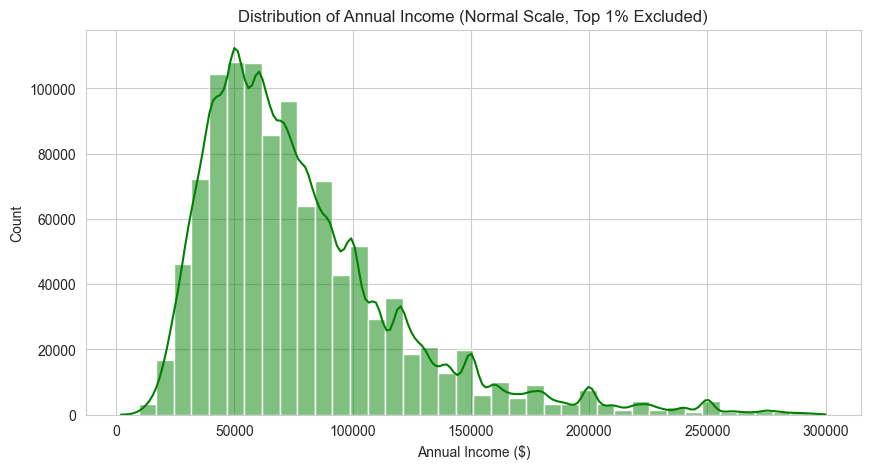

In [7]:
plt.figure(figsize=(10, 5))

subset = df[df['annual_inc'] < df['annual_inc'].quantile(0.99)]
sns.histplot(subset['annual_inc'], kde=True, color='green', bins=40)

plt.title("Distribution of Annual Income (Normal Scale, Top 1% Excluded)")
plt.xlabel("Annual Income ($)")
plt.ylabel("Count")
plt.show()

### 1.4 Interest Rate Distribution Features

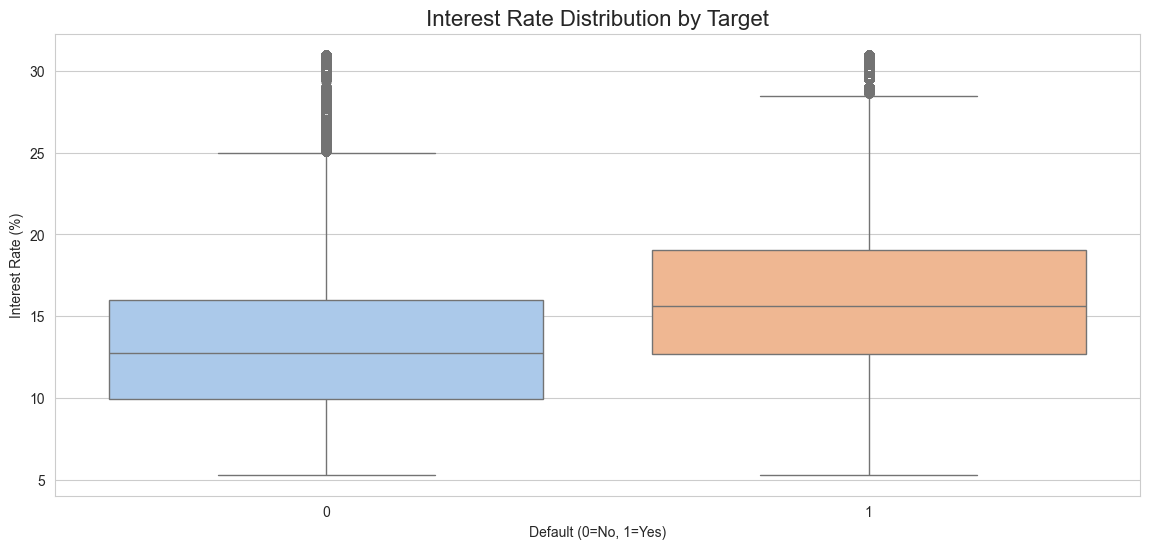

Mean Interest Rate for Non-Defaulters: 13.23%
Mean Interest Rate for Defaulters:     16.20%
💡 INSIGHT: Defaulters tend to have much higher interest rates. This confirms 'int_rate' contains critical risk information.


In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='target', y='int_rate', data=df, palette='pastel')
plt.title("Interest Rate Distribution by Target", fontsize=16)
plt.xlabel("Default (0=No, 1=Yes)")
plt.ylabel("Interest Rate (%)")

plt.show()

print(f"Mean Interest Rate for Non-Defaulters: {df[df['target']==0]['int_rate'].mean():.2f}%")
print(f"Mean Interest Rate for Defaulters:     {df[df['target']==1]['int_rate'].mean():.2f}%")
print("💡 INSIGHT: Defaulters tend to have much higher interest rates. This confirms 'int_rate' contains critical risk information.")

### 1.5 Heat Map 

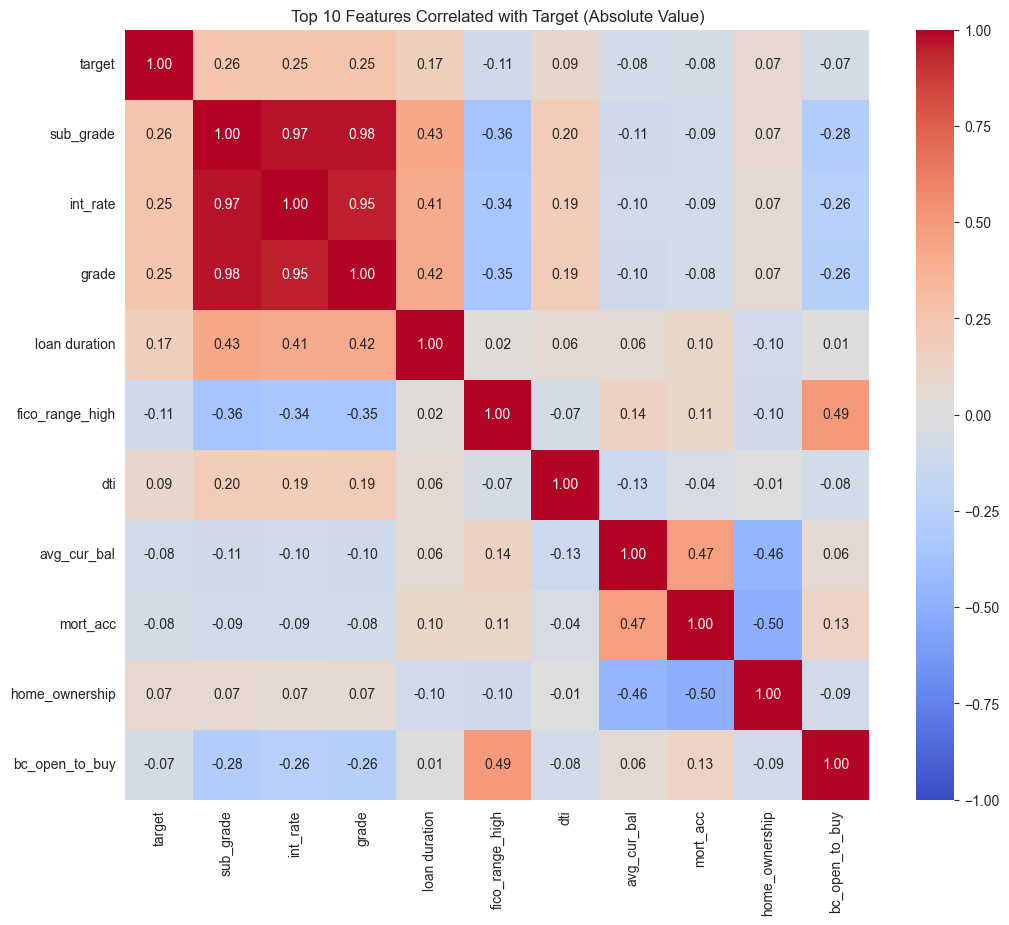

 Highly correlated features: ['target', 'sub_grade', 'int_rate', 'grade', 'loan duration', 'fico_range_high', 'dti', 'avg_cur_bal', 'mort_acc', 'home_ownership', 'bc_open_to_buy']


In [12]:
df_corr = df.copy()
le = LabelEncoder()
categorical_cols = ['grade', 'sub_grade', 'home_ownership', 'emp_length', 'purpose']

for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# 2.  Top 10 corrlated features
all_corr = df_corr.corr(numeric_only=True)['target'].abs().sort_values(ascending=False)
top_features = all_corr.head(11).index 

# 3. Heat Map
plt.figure(figsize=(12, 10))
final_corr = df_corr[top_features].corr()

sns.heatmap(final_corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Top 10 Features Correlated with Target (Absolute Value)")
plt.show()

print(f" Highly correlated features: {top_features.tolist()}")

### 1.6 Fairness Audit

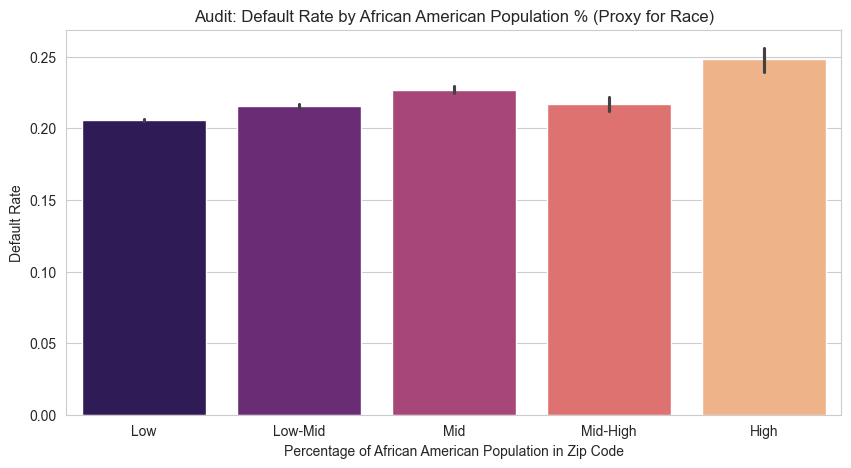

In [13]:
# Check Proxy Variables
df['ethnicity_bin'] = pd.cut(df['Pct_afro_american'], bins=5, labels=['Low', 'Low-Mid', 'Mid', 'Mid-High', 'High'])

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='ethnicity_bin', y='target', palette="magma")
plt.title("Audit: Default Rate by African American Population % (Proxy for Race)")
plt.xlabel("Percentage of African American Population in Zip Code")
plt.ylabel("Default Rate")
plt.show()

The data shows that areas with a higher proportion of African-American population have higher default rates. If we keep `zip_code` or `Pct_afro_american`, the model would inevitably learn racial biases, leading to **redlining**, which violates the **ECOA** (Equal Credit Opportunity Act).  

**Strategy:** For compliance reasons, these features must be excluded.


### 1.7 Temporal Analysis

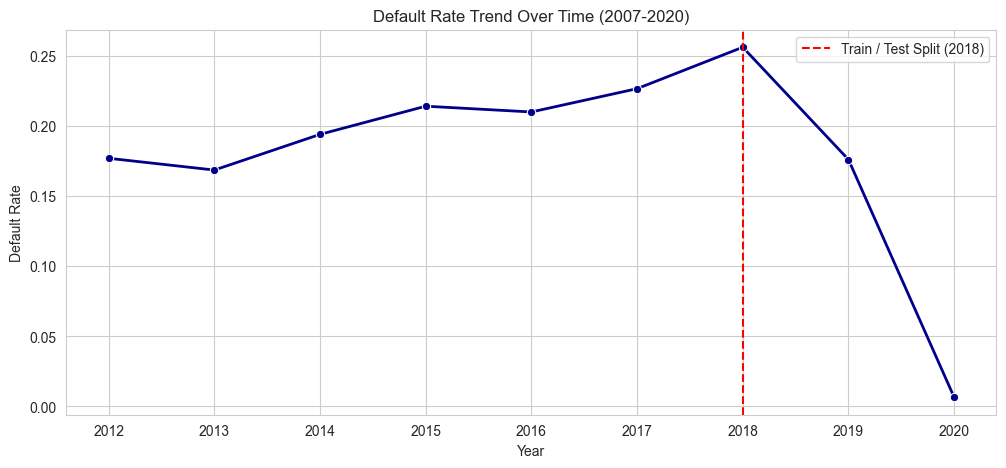

In [14]:
default_by_year = df.groupby('issue_d')['target'].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=default_by_year.index, y=default_by_year.values, marker='o', linewidth=2, color='darkblue')
plt.title("Default Rate Trend Over Time (2007-2020)")
plt.axvline(x=2018, color='red', linestyle='--', label='Train / Test Split (2018)')
plt.ylabel("Default Rate")
plt.xlabel("Year")
plt.legend()
plt.show()

### Subsequent Analysis

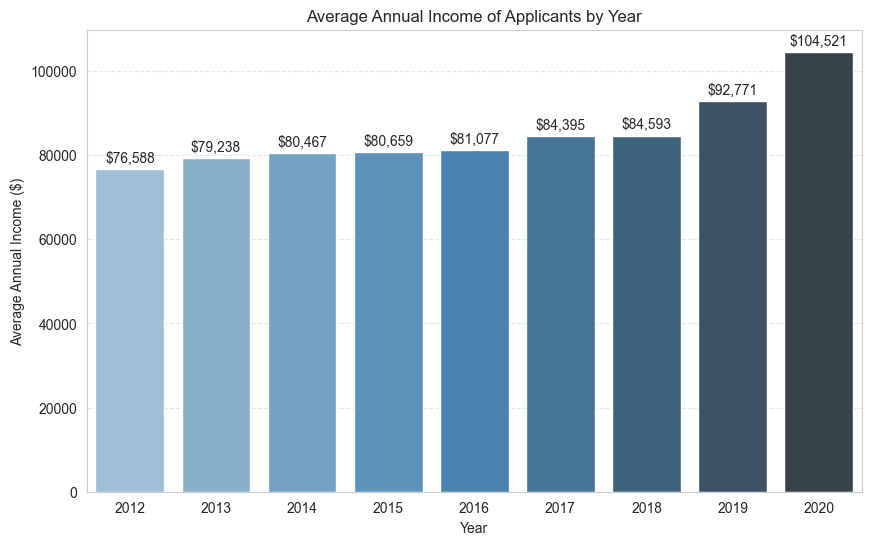

In [15]:

year_col = 'issue_d'
income_col = 'annual_inc'
avg_income_df = df.groupby(year_col)[income_col].mean().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=avg_income_df, x=year_col, y=income_col, palette="Blues_d")
plt.title("Average Annual Income of Applicants by Year")
plt.xlabel("Year")
plt.ylabel("Average Annual Income ($)")


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:,.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 8), 
                textcoords='offset points',
                fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5) 
plt.show()

Percentage Afro_african every year
   issue_d  Pct_afro_american
0     2012          12.732486
1     2013          12.463012
2     2014          12.775156
3     2015          12.904027
4     2016          13.089617
5     2017          13.076606
6     2018          12.853315
7     2019          12.618047
8     2020          12.470623


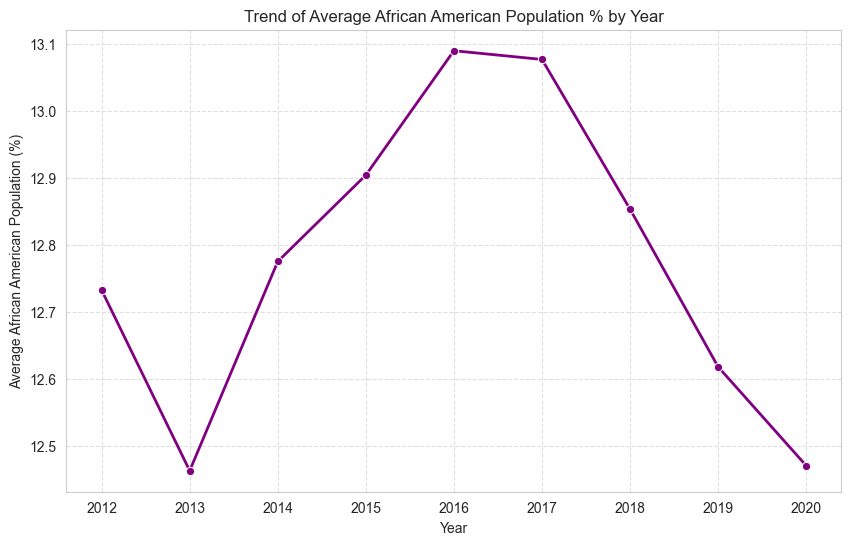

In [16]:
year_col = 'issue_d'
race_col = 'Pct_afro_american'


avg_race_df = df.groupby(year_col)[race_col].mean().reset_index()

print("Percentage Afro_african every year")
print(avg_race_df)

plt.figure(figsize=(10, 6))

sns.lineplot(data=avg_race_df, x=year_col, y=race_col, marker='o', linewidth=2, color='purple')

plt.title("Trend of Average African American Population % by Year")
plt.xlabel("Year")
plt.ylabel("Average African American Population (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(avg_race_df[year_col].unique())

plt.show()

# Part 2: Data Cleaning and Feature engineering 

In [20]:
df_final = df.copy()

# Annual Income to log
df_final['annual_inc_log'] = np.log1p(df_final['annual_inc'])
df_final.drop('annual_inc', axis=1, inplace=True, errors='ignore')


# One-Hot Encoding 
cols_to_dummy = ['home_ownership', 'purpose'] 
valid_dummy_cols = [c for c in cols_to_dummy if c in df_final.columns]
df_final = pd.get_dummies(df_final, columns=valid_dummy_cols, drop_first=True)

# Drop Colinéaire features and keep Int_rate
df_final.drop(['grade', 'sub_grade'], axis=1, inplace=True, errors='ignore')


numeric_cols = df_final.select_dtypes(include=[np.number]).columns
df_final[numeric_cols] = df_final[numeric_cols].fillna(df_final[numeric_cols].median())


# Categorical features transformation
emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
           '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
           '10+ years': 10}
df_final['emp_length_num'] = df_final['emp_length'].map(emp_map).fillna(0)
df_final.drop('emp_length', axis=1, inplace=True, errors='ignore')


#  'Unknown' 
categorical_cols = df_final.select_dtypes(include=['object']).columns
df_final[categorical_cols] = df_final[categorical_cols].fillna('Unknown')


features_to_drop = [
    'Predictions', 'Predicted probabilities',
    'zip_code', 'Pct_afro_american', 
    'issue_d', 'Unnamed: 0', 'emp_title', 'ethnicity_bin'
]

cols_to_drop = [col for col in features_to_drop if col in df_final.columns]
df_final = df_final.drop(cols_to_drop, axis=1)


print("--- Data Cleaning and Feature Engineering Final Report ---")
print(f"✅ Final shape: {df_final.shape}")
print("✅ Remaining Nulls:", df_final.isnull().sum().sum())
print(f"✅ Final features: {df_final.columns.tolist()}")

--- Data Cleaning and Feature Engineering Final Report ---
✅ Final shape: (1086236, 42)
✅ Remaining Nulls: 0
✅ Final features: ['loan duration', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high', 'funded_amnt', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'target', 'tax_liens', 'annual_inc_log', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'emp_length_num']


In [21]:
output_dir = '../data/processed/'
output_filename = 'Model_Training.csv'
output_path = os.path.join(output_dir, output_filename)

df_final.to_csv(output_path, index=False)

print(f"✅ Success! Processed data saved to: {output_path}")
print(f"Data shape: {df_final.shape}")

✅ Success! Processed data saved to: ../data/processed/Model_Training.csv
Data shape: (1086236, 42)
